In [1]:
import GPy
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import display
from tqdm import tqdm
import scipy
import time
import threading

import tensorflow as tf
import tf_agents
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()
np.random.seed(123)
random.seed(123)

import warnings
warnings.filterwarnings("ignore")

In [2]:
def flatten(liste):
    return [item for sublist in liste for item in sublist]

def preprocessing(X_s):
    X = []
    for liste in X_s:
        X += liste.copy()
    return np.array(X)

def copie_paths(paths):
    X = []
    for liste in paths:
        X.append(liste.copy())
    return X

def copy_X_D(X_D):
    X = []
    for liste in X_D:
        X.append(liste.copy())
    return np.array(X)

def concatenate(x, y):
    if len(x)==0:
        return y
    else:
        return np.concatenate((x, y))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def distance(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
        
def sigma_matrix(gp_model, X_v):
    return gp_model.kern.K(X_v, X_v)
    
def sigma_prime_matrix(gp_model, X_v, X_s):
    kernel = gp_model.rbf
    variance_n = float(gp_model.Gaussian_noise.variance)
    a = kernel.K(X_v, X_v)
    b = kernel.K(X_v, X_s)
    c = kernel.K(X_s, X_s)
    d = variance_n*np.eye(len(X_s))
    e = kernel.K(X_s, X_v)
    f = np.linalg.inv(c + d)
    g = np.dot(b, f)
    h = np.dot(g, e)
    return a - h

def reward_function(gp_model, X_v, X_s_old, X_s_new):
    if len(X_s_old)==0:
        sigma_prime_old = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_old = sigma_prime_matrix(gp_model, X_v, X_s_old)
    if len(X_s_new)==0:
        sigma_prime_new = sigma_matrix(gp_model, X_v)
    else:
        sigma_prime_new = sigma_prime_matrix(gp_model, X_v, X_s_new)
    return 0.5 * (np.log(np.linalg.det(sigma_prime_old)) - np.log(np.linalg.det(sigma_prime_new)))

def credit_assignment(env, reward, dones):
    if env.nb_agents==1:
        return np.array([reward])
    rewards = np.zeros(env.nb_agents)
    if reward==0:
        return rewards
    X_s = preprocessing(env.X_s)
    H = np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s)))
    for i in range(env.nb_agents):
        if not dones[i]:
            X_s_i = env.X_s.copy()
            del X_s_i[i]
            X_s_i = preprocessing(X_s_i)
            if len(X_s_i)==0:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_matrix(env.gp_model, env.X_v))) - H)
            else:
                rewards[i] = 0.5 * (np.log(np.linalg.det(sigma_prime_matrix(env.gp_model, env.X_v, X_s_i))) - H)
    somme = np.sum(rewards)
    if somme==0:
        return rewards
    return rewards*(reward/(np.sum(rewards)))

def construct_graph(graph_dim, graph_unity):
    x = graph_dim[0]
    y = graph_dim[1]
    i, j = 0.0, 0.0
    graph = nx.Graph()
    for k in range(x*y):
        graph.add_node(k, coord=[i, j])
        i += graph_unity
        if i==x*graph_unity:
            i = 0.0
            j += graph_unity
    for k in range(x*y):
        if (k+1)%x!=0:
            graph.add_edge(k, k+1)
        if k<x*y-x:
            graph.add_edge(k, k+x)
    return graph
            
def show_graph(graph):
    nx.draw(graph, with_labels=True, font_weight='bold')

def remove_nodes_from_graph(graph, liste):
    graph.remove_nodes_from(liste)
    return graph

def incertitude_initiale(sigma, graph):
    return 0.5 * np.log(np.linalg.det(sigma)) + (graph.number_of_nodes()/2) * (1 + np.log(2*np.pi))

def coord_to_id(coord, graph_dim):
    return graph_dim[0] * int(coord[1]) + int(coord[0])

In [3]:
def collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance, lengthscale, memory_window, gamma):
    X_D = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance, lengthscale=lengthscale)
    cov = simulation_kernel.K(X_D)
    X, Y = [], []
    for _ in range(exploration_steps):
        Y_D = np.random.multivariate_normal(np.array(means), cov, 1)[0]
        Y_D = np.reshape(Y_D, (len(Y_D),1))
        Y_D[Y_D<0] = 0.1
        sparse_nodes = random.sample(range(0, graph.number_of_nodes()), nb_agents)
        sorted_nodes = sorted(sparse_nodes)
        if sorted_nodes[0]==0:
            for i in range(1,len(sorted_nodes)):
                if sorted_nodes[i]!=sorted_nodes[i-1]:
                    l = covariances[sorted_nodes[i]-1]
                    l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_D[0], Y_D[sorted_nodes[i]], memory_window, gamma)
        X.append(X_D[sparse_nodes])
        Y.append(Y_D[sparse_nodes])
    return incertitude_initiale(cov, graph), np.array(X), np.array(Y)

def hyperparameters_estimator(X, Y, gp_model, graph, graph_dim, memory_window, gamma):
    for i in range(len(X)):
        l = variances[coord_to_id(X[i], graph_dim)]
        l[0], l[1], l[2] = weighted_variance(l[0], l[1], l[2], Y[i][0], memory_window, gamma)
    cumul_var = 0
    coeffs = 0
    for ele in variances:
        coeffs += ele[2]
        cumul_var += float(ele[0])*ele[2]
    variance = cumul_var/coeffs
    ###########################################
    X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
    moyenne = np.reshape(gp_model.predict(X_v)[0], (graph.number_of_nodes(),))
    ###########################################
    lengthscale, cpt = 0, 0
    for i in range(len(covariances)):
        if covariances[i][0]>1:
            covariance = covariances[i][1] - covariances[i][2]*covariances[i][3]
            if 0<covariance<variance:
                cpt += covariances[i][0]
                lengthscale += find_lengthscale(X_v[0], X_v[i+1], covariance, variance) * covariances[i][0]
    if cpt!=0:
        lengthscale /= cpt
    else:
        lengthscale = 0
    return moyenne, variance, lengthscale

def find_lengthscale(x1, x2, y, var):
    return distance(x1, x2) * np.sqrt(-0.5/np.log(y/var))

def weighted_covariance(n, moy_prod, moy_x, moy_y, x_new, y_new, memory_capacity, gamma):
    if n>memory_capacity:
        return n + 1, gamma * moy_prod + (1-gamma) * x_new * y_new, gamma * moy_x + (1-gamma) * x_new, gamma * moy_y + (1-gamma) * y_new
    return n + 1, (n * moy_prod + x_new * y_new)/(n + 1), (n * moy_x + x_new)/(n + 1), (n * moy_y + y_new)/(n + 1)

def weighted_variance(var, moy, n, x_new, memory_capacity, gamma):
    if n>memory_capacity:
        a = gamma*(var+(moy**2)) + (1-gamma)*(x_new**2)
        moy = gamma * moy + (1-gamma) * x_new
    else:
        a = (n*(var+(moy**2)) + (x_new**2))/(n+1)
        moy = (n*moy+x_new)/(n+1)
    return a-moy**2, moy, n+1

def in_collision(env, agent):
    for i in range(env.nb_agents):
        if i!=agent and env.paths[i][-1]==env.paths[agent][-1]:
            return True
    return False
    
def nb_agents_in_collision(env):
    cpt = 0
    for agent in range(env.nb_agents):
        if in_collision(env, agent):
            cpt += 1
    return cpt

In [4]:
graph_dim = (5, 5)
graph_unity = 1
graph = construct_graph(graph_dim, graph_unity)
X_v = np.array([graph.nodes[i]["coord"] for i in range(graph.number_of_nodes())])
means = [60, 30, 20, 15, 10, 30, 27.5, 25, 17.5, 11.25, 20, 25, 22.5, 20, 12.5, 15, 17.5, 20, 17.5, 15, 10, 11.25, 12.5, 15, 12.5]
nb_agents = 3
exploration_steps = 25
variance_lengthscale = [10, 2]
memory_window = 1000
gamma = 0.997

variances = [[0, 0, 0] for _ in range(graph.number_of_nodes())]
covariances = [[0, 0, 0, 0] for _ in range(graph.number_of_nodes()-1)]

incertitude, x, y = collect_pilot_data(nb_agents, exploration_steps, graph, graph_dim, means, variance_lengthscale[0], variance_lengthscale[1], memory_window, gamma)

x = np.reshape(x, (nb_agents*exploration_steps,2))
y = np.reshape(y, (nb_agents*exploration_steps,1))

gp_model = GPy.models.GPRegression(x, y, GPy.kern.RBF(2))
gp_model.optimize(messages=False)

moyenne, var, l = hyperparameters_estimator(x, y, gp_model, graph, graph_dim, memory_window, gamma)
print("Variance: ", var)
print("Lengthscale: ", l)
print("Carte: ", moyenne)
print("Incertitude initiale : ", incertitude_initiale(sigma_matrix(gp_model, X_v), graph))

Variance:  6.630500994933553
Lengthscale:  [1.33462695]
Carte:  [61.42182314 30.70830029 18.24825012 14.60216164 11.17113024 32.32974597
 23.91409301 24.45371176 18.73139786 10.29112404 18.15012332 21.01698463
 24.29303785 17.92047225 10.56134434 13.03002171 15.47067502 18.72326228
 18.00522531 16.03398151  9.67046301 11.76729391 15.56039682 15.7214703
 11.54153804]
Incertitude initiale :  81.94223693030234


In [5]:
def update_gp_model(gp_model, x, y, graph, graph_dim, memory_window, gamma, display_gp_model=False):
    moy, variance, lengthscale = hyperparameters_estimator(x, y, gp_model, graph, graph_dim, memory_window, gamma)
    X = np.concatenate((gp_model.X, x))[-1000:]
    Y = np.concatenate((gp_model.Y, y))[-1000:]
    gp_model.set_XY(X, Y)
    gp_model.optimize(messages=False)
    if display_gp_model:
        display(gp_model)
    return gp_model, moy, variance, lengthscale

def take_measurements(nodes, means, X_v, memory_window, gamma):
    simulation_kernel = GPy.kern.RBF(input_dim = 2, variance=variance_lengthscale[0], lengthscale=variance_lengthscale[1])
    cov = simulation_kernel.K(X_v)
    Y_v = np.random.multivariate_normal(np.array(means), cov, 1)[0]
    Y_v = np.reshape(Y_v, (len(Y_v),1))
    Y_v[Y_v<0] = 0.1
    sorted_nodes = sorted(nodes)
    if sorted_nodes[0]==0:
        for i in range(1,len(sorted_nodes)):
            if sorted_nodes[i]!=sorted_nodes[i-1]:
                l = covariances[sorted_nodes[i]-1]
                l[0], l[1], l[2], l[3] = weighted_covariance(l[0], l[1], l[2], l[3], Y_v[0], Y_v[sorted_nodes[i]], memory_window, gamma)
    return X_v[nodes], Y_v[nodes]

In [6]:
class pfeEnv(py_environment.PyEnvironment):

    def __init__(self, graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, variance_0, lengthscale_0, memory_window, gamma, train_env=True):
        self.nb_agents = nb_agents
        self.graph = graph
        self.graph_unity = graph_unity
        self.graph_dim = graph_dim
        self.initial_budgets = budgets/self.graph_unity
        self.budgets = self.initial_budgets.copy()
        if initial_positions!=None:
            self.initial_positions = copie_paths(initial_positions)
            self.paths = copie_paths(initial_positions)
        else:
            self.initial_positions = None
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        self.X_v = np.array([self.graph.nodes[i]["coord"] for i in range(self.graph.number_of_nodes())])
        self.gp_model = gp_model
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=3, name="action")
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.nb_agents*2,), dtype=np.float32, minimum=np.zeros((self.nb_agents*2,)), name="observation")
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self._episode_ended = False
        #################################
        self.cpt_update_gp_model = 0
        self.memory_window, self.gamma = memory_window, gamma
        self.x, self.y = np.array([]), np.array([])
        self.liste_variances, self.liste_lengthscales = [variance_0], [lengthscale_0]
        self.train_env = train_env
        self.agents_in_collision = []
        
    def current_node(self, id_agent):
        return self.paths[id_agent][-1]

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def formater(self):
        for i in range(len(self.neighbors)):
            liste = self.neighbors[i]
            node = self.current_node(i)
            try:
                if liste[0]>=node-1:
                    liste.insert(0,-1)
                if liste[1]!=node-1:
                    liste.insert(1,-1)
                if liste[2]!=node+1:
                    liste.insert(2,-1)
            except:
                pass
            for _ in range(4-len(liste)):
                liste.append(-1)

    def _reset(self):
        if self.initial_positions!=None:
            self.paths = copie_paths(self.initial_positions)
        else:
            self.paths = [[random.randint(0, self.graph.number_of_nodes()-1)] for i in range(self.nb_agents)]
        self._state = flatten([self.graph.nodes[self.current_node(i)]["coord"] for i in range(self.nb_agents)])
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)] 
        self.formater()
        self.budgets = self.initial_budgets.copy()
        self.X_s = [[] for i in range(self.nb_agents)]
        self.dones = [False for i in range(self.nb_agents)]
        self.cpt_done = 0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))
        
    def _step(self, abstract_actions):
        if self._episode_ended:
            return self.reset()
        actions = []
        for i in range(self.nb_agents):
            actions.append(self.neighbors[i][abstract_actions[i]])
        X_s_old = preprocessing(self.X_s)
        for i in range(self.nb_agents):
            if not self.dones[i]:
                if actions[i]!=-1:
                    self.X_s[i].append([graph.nodes[actions[i]]["coord"][0], graph.nodes[actions[i]]["coord"][1]])
                    self.budgets[i] -= 1
                else:
                    actions[i] = self.current_node(i)
                    self.budgets[i] -= 0.3
                if self.budgets[i]<1:
                    self.dones[i] = True
                    self.cpt_done += 1
                self.paths[i].append(actions[i])
                coord = self.graph.nodes[self.current_node(i)]["coord"]
                self._state[2*i] = coord[0]
                self._state[2*i+1] = coord[1]
        
        if self.train_env:
            positions, mesures = take_measurements(actions, means, self.X_v, self.memory_window, self.gamma)
            self.x = concatenate(self.x, positions)
            self.y = concatenate(self.y, mesures)
            self.cpt_update_gp_model = (self.cpt_update_gp_model + 1)%100
            if self.cpt_update_gp_model==0:
                self.gp_model, m, var, l = update_gp_model(self.gp_model, self.x, self.y, self.graph, self.graph_dim, self.memory_window, self.gamma)
                self.liste_variances.append(var)
                self.liste_lengthscales.append(l)
                self.moy = m
                self.x, self.y = np.array([]), np.array([])
        
        self.neighbors = [sorted(list(self.graph.neighbors(self.current_node(i)))) for i in range(self.nb_agents)]
        self.formater()
        reward = reward_function(self.gp_model, self.X_v, X_s_old, preprocessing(self.X_s))
        nb = nb_agents_in_collision(self)
        self.agents_in_collision.append(nb)
        reward -= (reward * nb * 0.1)
        if self.cpt_done==self.nb_agents:
            self._episode_ended = True
            return ts.termination(np.array(self._state, dtype=np.float32), reward)
        return ts.transition(np.array(self._state, dtype=np.float32), reward=reward, discount=0.97)

In [7]:
num_iterations = 50000
fc_layer_params = (128,64,)
replay_buffer_capacity = 300000
batch_size = 128
learning_rate = 1e-5

num_atoms = 51
min_q_value = -20
max_q_value = 20
n_step_update = 3
gamma = 0.99

num_eval_episodes = 10
log_eval_interval = 1000

max_episode_length = 25
budgets = 25 * np.ones(nb_agents)

In [8]:
initial_positions = None #[[random.randint(0, graph.number_of_nodes()-1)] for i in range(nb_agents)]
train_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=True), duration=max_episode_length)
eval_py_env = wrappers.TimeLimit(pfeEnv(graph, gp_model, nb_agents, budgets, graph_unity, graph_dim, initial_positions, var, l, memory_window, gamma, train_env=False), duration=max_episode_length)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

agents_tf = []
eval_policies = []
collect_policies = []
policies_checkpointers = []

for i in range(nb_agents):
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        fc_layer_params=fc_layer_params)
        
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)

    agents_tf.append(categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        min_q_value=min_q_value,
        max_q_value=max_q_value,
        n_step_update=n_step_update,
        target_update_period=5,
        target_update_tau=0.05,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        train_step_counter=train_step_counter))

    agents_tf[-1].initialize()

    eval_policies.append(agents_tf[-1].policy)
    collect_policies.append(agents_tf[-1].collect_policy)
    
    policies_checkpointers.append(common.Checkpointer(ckpt_dir='Collisions_Politique_'+str(i), policy=eval_policies[-1]))

In [9]:
def compute_avg_return(environment, policies, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            actions = []
            for i in range(nb_agents):
                actions.append(policies[i].action(time_step).action.numpy()[0])
            actions = tf.convert_to_tensor([actions])
            time_step = environment.step(actions)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def collect_step(environment, environment_py, policies):
    time_step = environment.current_time_step()
    actions = []
    actions_step = []
    dones = environment_py.dones.copy()
    for i in range(nb_agents):
        actions_step.append(policies[i].action(time_step))
        actions.append(actions_step[-1].action.numpy()[0])
    actions = tf.convert_to_tensor([actions])
    next_time_step = environment.step(actions)
    rewards = credit_assignment(environment_py, next_time_step.reward.numpy()[0], dones)
    for i in range(nb_agents):
        if not dones[i]:
            nts = next_time_step._replace(reward=tf.convert_to_tensor([rewards[i]], dtype=np.float32))
            traj = trajectory.from_transition(time_step, actions_step[i], nts)
            replay_buffers[i].add_batch(traj)

In [11]:
replay_buffers = []
for i in range(nb_agents):
    replay_buffers.append(tf_agents.replay_buffers.TFUniformReplayBuffer(
        data_spec = agents_tf[i].collect_data_spec,
        batch_size = train_env.batch_size,
        max_length = replay_buffer_capacity))

iterators = []
for i in range(nb_agents):
    dataset = replay_buffers[i].as_dataset(
        num_parallel_calls=3,
        sample_batch_size=batch_size,
        num_steps=2).prefetch(3)

    iterators.append(iter(dataset))

In [12]:
print(compute_avg_return(eval_env, eval_policies, num_eval_episodes))

steps = []
avg = []
err = []

for i in range(nb_agents):
    agents_tf[i].train = common.function(agents_tf[i].train)
    agents_tf[i].train_step_counter.assign(0)

for _ in tqdm(range(500)):
    collect_step(train_env, train_py_env, collect_policies)
    
for step in tqdm(range(1, num_iterations+1)):
    for _ in range(1):
        collect_step(train_env, train_py_env, collect_policies)
    
    for i in range(nb_agents):
        experience, _ = next(iterators[i])
        agents_tf[i].train(experience=experience)

    if step%log_eval_interval==0:
        avg_return = compute_avg_return(eval_env, eval_policies, num_eval_episodes)
        steps.append(step)
        avg.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        print("Variance : ", train_py_env.liste_variances[-1])
        print("Lengthscale : ", train_py_env.liste_lengthscales[-1])
        err.append(np.mean((train_py_env.moy-means)**2))
        print("MSE de la moyenne : ", err[-1])

9.904532


  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  2%|█▌                                                                         | 1006/50000 [00:59<2:48:48,  4.84it/s]

step = 1000: Average Return = 20.01329231262207
Variance :  9.872951821209508
Lengthscale :  [2.03421286]
MSE de la moyenne :  0.44188739586996123


  4%|███                                                                        | 2004/50000 [01:58<4:12:01,  3.17it/s]

step = 2000: Average Return = 22.661256790161133
Variance :  9.887035369738735
Lengthscale :  [2.26858698]
MSE de la moyenne :  0.2064107824883748


  6%|████▌                                                                      | 3004/50000 [02:54<3:55:21,  3.33it/s]

step = 3000: Average Return = 25.832983016967773
Variance :  9.829479135573688
Lengthscale :  [2.12092641]
MSE de la moyenne :  0.8031792187697306


  8%|██████                                                                     | 4004/50000 [03:55<3:59:43,  3.20it/s]

step = 4000: Average Return = 27.40167236328125
Variance :  9.655170545319644
Lengthscale :  [2.20492608]
MSE de la moyenne :  1.0924630697843214


 10%|███████▌                                                                   | 5005/50000 [05:01<3:52:35,  3.22it/s]

step = 5000: Average Return = 34.74403762817383
Variance :  9.83247742027021
Lengthscale :  [2.11389059]
MSE de la moyenne :  13.206958410267193


 12%|█████████                                                                  | 6004/50000 [06:10<3:45:21,  3.25it/s]

step = 6000: Average Return = 37.26525115966797
Variance :  9.816303280521165
Lengthscale :  [2.14510987]
MSE de la moyenne :  0.9284685717821942


 14%|██████████▌                                                                | 7004/50000 [07:12<4:01:18,  2.97it/s]

step = 7000: Average Return = 44.795387268066406
Variance :  10.002169796670142
Lengthscale :  [2.09161337]
MSE de la moyenne :  0.5070982553720452


 16%|████████████                                                               | 8003/50000 [08:19<3:33:51,  3.27it/s]

step = 8000: Average Return = 37.56241226196289
Variance :  9.831223932149008
Lengthscale :  [2.11795099]
MSE de la moyenne :  1.0545830153179159


 18%|█████████████▌                                                             | 9002/50000 [09:30<5:41:42,  2.00it/s]

step = 9000: Average Return = 42.35737991333008
Variance :  9.978058196661085
Lengthscale :  [2.09224657]
MSE de la moyenne :  144.38564901839308


 20%|██████████████▊                                                           | 10002/50000 [10:45<5:43:35,  1.94it/s]

step = 10000: Average Return = 43.360286712646484
Variance :  9.786545935805771
Lengthscale :  [2.11529343]
MSE de la moyenne :  0.30670089244848237


 22%|████████████████▎                                                         | 11004/50000 [11:54<3:46:28,  2.87it/s]

step = 11000: Average Return = 41.18567657470703
Variance :  10.008660417504261
Lengthscale :  [2.27562246]
MSE de la moyenne :  1.5646710000953261


 24%|█████████████████▊                                                        | 12002/50000 [13:04<5:33:17,  1.90it/s]

step = 12000: Average Return = 48.03594207763672
Variance :  9.976401583008435
Lengthscale :  [1.96773649]
MSE de la moyenne :  0.6086052837677316


 26%|███████████████████▏                                                      | 13003/50000 [14:12<3:43:35,  2.76it/s]

step = 13000: Average Return = 49.339412689208984
Variance :  10.044457519753141
Lengthscale :  [1.99180533]
MSE de la moyenne :  0.18746781700598883


 28%|████████████████████▋                                                     | 14003/50000 [15:21<3:36:13,  2.77it/s]

step = 14000: Average Return = 52.67887496948242
Variance :  9.887104836313082
Lengthscale :  [1.99533358]
MSE de la moyenne :  0.16066932766424963


 30%|██████████████████████▏                                                   | 15004/50000 [16:32<4:44:24,  2.05it/s]

step = 15000: Average Return = 53.55083084106445
Variance :  10.113593330096078
Lengthscale :  [2.02720957]
MSE de la moyenne :  0.39524033622895816


 32%|███████████████████████▋                                                  | 16004/50000 [17:41<3:17:01,  2.88it/s]

step = 16000: Average Return = 52.75470733642578
Variance :  10.179399872377656
Lengthscale :  [1.96507902]
MSE de la moyenne :  0.42314589671171293


 34%|█████████████████████████▏                                                | 17003/50000 [18:57<3:15:26,  2.81it/s]

step = 17000: Average Return = 54.25934600830078
Variance :  9.901200529151522
Lengthscale :  [2.20088951]
MSE de la moyenne :  0.1679491042690165


 36%|██████████████████████████▋                                               | 18002/50000 [20:07<4:20:59,  2.04it/s]

step = 18000: Average Return = 54.14091873168945
Variance :  9.520304087192931
Lengthscale :  [1.95500045]
MSE de la moyenne :  0.2874990736982372


 38%|████████████████████████████                                              | 19002/50000 [21:18<4:08:45,  2.08it/s]

step = 19000: Average Return = 55.24153518676758
Variance :  9.6138431647525
Lengthscale :  [1.92560519]
MSE de la moyenne :  0.49039595029112876


 40%|█████████████████████████████▌                                            | 20004/50000 [22:30<3:14:23,  2.57it/s]

step = 20000: Average Return = 54.06092071533203
Variance :  10.177442889419861
Lengthscale :  [1.88441775]
MSE de la moyenne :  0.18029235693055048


 42%|███████████████████████████████                                           | 21005/50000 [23:40<2:53:39,  2.78it/s]

step = 21000: Average Return = 52.76927947998047
Variance :  9.742195573794135
Lengthscale :  [1.91134495]
MSE de la moyenne :  0.24380773263226233


 44%|████████████████████████████████▌                                         | 22003/50000 [24:47<2:25:59,  3.20it/s]

step = 22000: Average Return = 54.0025634765625
Variance :  10.15968444245516
Lengthscale :  [1.90633758]
MSE de la moyenne :  0.48851706791484184


 46%|██████████████████████████████████                                        | 23002/50000 [25:52<4:14:07,  1.77it/s]

step = 23000: Average Return = 52.25199508666992
Variance :  9.980257863386894
Lengthscale :  [1.96892486]
MSE de la moyenne :  0.3721055530382283


 48%|███████████████████████████████████▌                                      | 24002/50000 [27:04<3:39:04,  1.98it/s]

step = 24000: Average Return = 54.834197998046875
Variance :  9.620689273521489
Lengthscale :  [1.95531425]
MSE de la moyenne :  0.37752327106208655


 50%|█████████████████████████████████████                                     | 25003/50000 [28:16<2:37:09,  2.65it/s]

step = 25000: Average Return = 57.118919372558594
Variance :  9.671339063180834
Lengthscale :  [2.00762662]
MSE de la moyenne :  0.2914709938448388


 52%|██████████████████████████████████████▍                                   | 26003/50000 [29:25<2:21:23,  2.83it/s]

step = 26000: Average Return = 53.25762939453125
Variance :  9.622862564671573
Lengthscale :  [2.04402398]
MSE de la moyenne :  0.3852274133142656


 54%|███████████████████████████████████████▉                                  | 27003/50000 [30:37<2:15:03,  2.84it/s]

step = 27000: Average Return = 55.81640625
Variance :  9.783602687776405
Lengthscale :  [1.91746973]
MSE de la moyenne :  0.26987307775144864


 56%|█████████████████████████████████████████▍                                | 28004/50000 [31:51<2:50:49,  2.15it/s]

step = 28000: Average Return = 55.47914505004883
Variance :  9.867224839146072
Lengthscale :  [1.97253987]
MSE de la moyenne :  0.45040223023078674


 58%|██████████████████████████████████████████▉                               | 29004/50000 [33:06<2:02:13,  2.86it/s]

step = 29000: Average Return = 49.97078323364258
Variance :  10.085372940143012
Lengthscale :  [1.90994477]
MSE de la moyenne :  0.12113615144618124


 60%|████████████████████████████████████████████▍                             | 30003/50000 [34:20<2:23:57,  2.32it/s]

step = 30000: Average Return = 57.20764923095703
Variance :  10.036927789268695
Lengthscale :  [1.90793961]
MSE de la moyenne :  0.3756578661741657


 62%|█████████████████████████████████████████████▉                            | 31004/50000 [35:28<1:38:41,  3.21it/s]

step = 31000: Average Return = 53.51543426513672
Variance :  9.771215105027844
Lengthscale :  [1.90665185]
MSE de la moyenne :  0.24691927786679407


 64%|███████████████████████████████████████████████▎                          | 32005/50000 [36:30<1:31:06,  3.29it/s]

step = 32000: Average Return = 50.87620544433594
Variance :  9.634546609962063
Lengthscale :  [1.88265701]
MSE de la moyenne :  0.23659842319848987


 66%|████████████████████████████████████████████████▊                         | 33005/50000 [37:33<1:34:03,  3.01it/s]

step = 33000: Average Return = 50.0093879699707
Variance :  9.68419249991781
Lengthscale :  [1.88457546]
MSE de la moyenne :  0.3357626203260666


 68%|██████████████████████████████████████████████████▎                       | 34003/50000 [38:35<1:39:01,  2.69it/s]

step = 34000: Average Return = 55.56243133544922
Variance :  9.740298195009364
Lengthscale :  [1.88682671]
MSE de la moyenne :  0.3508024553263219


 70%|███████████████████████████████████████████████████▊                      | 35005/50000 [39:38<1:17:31,  3.22it/s]

step = 35000: Average Return = 47.61467361450195
Variance :  10.01283527932995
Lengthscale :  [1.88253177]
MSE de la moyenne :  0.3714310763810792


 72%|█████████████████████████████████████████████████████▎                    | 36001/50000 [40:39<1:37:55,  2.38it/s]

step = 36000: Average Return = 58.065032958984375
Variance :  10.091154091703835
Lengthscale :  [2.15261737]
MSE de la moyenne :  0.24866158612015782


 74%|██████████████████████████████████████████████████████▊                   | 37003/50000 [41:42<1:06:36,  3.25it/s]

step = 37000: Average Return = 57.092857360839844
Variance :  9.73107226635382
Lengthscale :  [1.97588261]
MSE de la moyenne :  0.1604065723767882


 76%|████████████████████████████████████████████████████████▏                 | 38002/50000 [42:44<1:27:07,  2.30it/s]

step = 38000: Average Return = 58.05580520629883
Variance :  10.023101008028645
Lengthscale :  [2.07855418]
MSE de la moyenne :  0.3312914997571741


 78%|███████████████████████████████████████████████████████████▎                | 39004/50000 [43:44<56:53,  3.22it/s]

step = 39000: Average Return = 55.959938049316406
Variance :  9.934311101139722
Lengthscale :  [2.05604393]
MSE de la moyenne :  0.269982631781689


 80%|████████████████████████████████████████████████████████████▊               | 40005/50000 [44:47<51:00,  3.27it/s]

step = 40000: Average Return = 55.9630126953125
Variance :  9.86644734993577
Lengthscale :  [2.0632793]
MSE de la moyenne :  0.3263845075310594


 82%|████████████████████████████████████████████████████████████▋             | 41004/50000 [45:50<1:02:32,  2.40it/s]

step = 41000: Average Return = 55.63127517700195
Variance :  9.896542388675
Lengthscale :  [2.02545014]
MSE de la moyenne :  0.24842173830349384


 84%|███████████████████████████████████████████████████████████████▊            | 42004/50000 [46:52<40:53,  3.26it/s]

step = 42000: Average Return = 59.19404220581055
Variance :  9.615659693069992
Lengthscale :  [2.5398389]
MSE de la moyenne :  0.3834129760452955


 86%|█████████████████████████████████████████████████████████████████▎          | 43004/50000 [47:55<36:05,  3.23it/s]

step = 43000: Average Return = 56.58498001098633
Variance :  9.69619587450072
Lengthscale :  [2.05624599]
MSE de la moyenne :  0.28849317953036346


 88%|██████████████████████████████████████████████████████████████████▉         | 44005/50000 [48:56<30:37,  3.26it/s]

step = 44000: Average Return = 54.06273651123047
Variance :  10.020861317936653
Lengthscale :  [1.94901353]
MSE de la moyenne :  0.14887929793325516


 90%|████████████████████████████████████████████████████████████████████▍       | 45003/50000 [49:58<25:44,  3.24it/s]

step = 45000: Average Return = 54.649314880371094
Variance :  10.061233263396225
Lengthscale :  [1.94697854]
MSE de la moyenne :  0.29065475035001315


 92%|█████████████████████████████████████████████████████████████████████▉      | 46004/50000 [51:01<22:09,  3.01it/s]

step = 46000: Average Return = 49.105628967285156
Variance :  9.811763350446691
Lengthscale :  [1.97720395]
MSE de la moyenne :  0.35782529835097726


 94%|███████████████████████████████████████████████████████████████████████▍    | 47005/50000 [52:02<15:07,  3.30it/s]

step = 47000: Average Return = 44.692745208740234
Variance :  9.717078670905874
Lengthscale :  [1.96132782]
MSE de la moyenne :  0.27887588683513204


 96%|████████████████████████████████████████████████████████████████████████▉   | 48004/50000 [53:04<10:13,  3.25it/s]

step = 48000: Average Return = 48.747642517089844
Variance :  9.91045586865141
Lengthscale :  [1.96851759]
MSE de la moyenne :  0.18079297552460852


 98%|██████████████████████████████████████████████████████████████████████████▍ | 49001/50000 [54:04<06:56,  2.40it/s]

step = 49000: Average Return = 54.5838623046875
Variance :  9.93669693507247
Lengthscale :  [1.9695471]
MSE de la moyenne :  0.23717226268681105


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [55:07<00:00, 15.11it/s]

step = 50000: Average Return = 55.077720642089844
Variance :  9.351248321423547
Lengthscale :  [1.98386921]
MSE de la moyenne :  0.2722623524097057


## Avec pénalisation des collisions

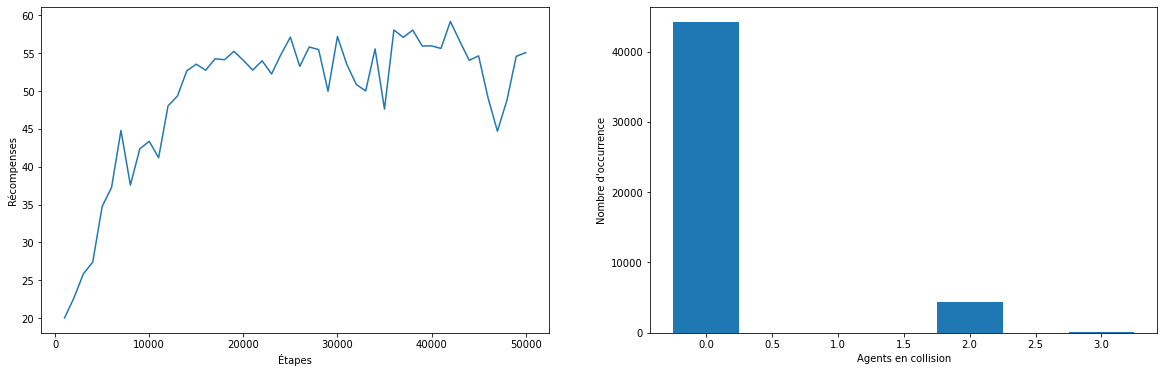

In [13]:
bins = []
for x in range(nb_agents+1):
    bins.append(x-0.5)
    bins.append(x+0.5)
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(steps, avg)
plt.xlabel("Étapes")
plt.ylabel("Récompenses")
plt.subplot(1, 2, 2)
plt.hist(train_py_env.agents_in_collision, bins=bins, rwidth=0.5)
plt.xlabel("Agents en collision")
plt.ylabel("Nombre d'occurrence")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


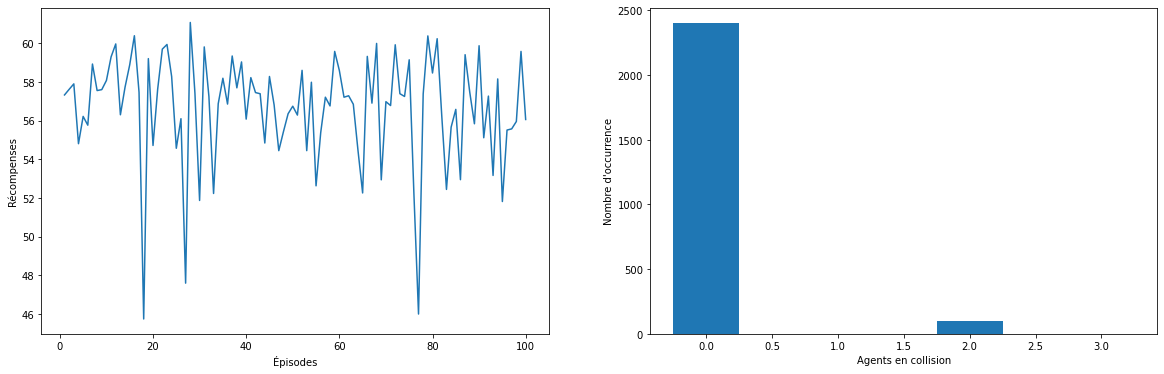

In [14]:
rewards = []
episodes = 100
a = len(eval_py_env.agents_in_collision)
for _ in tqdm(range(episodes)):
    time_step = eval_env.reset()
    episode_return = 0.0
    while not time_step.is_last():
        actions = []
        for i in range(nb_agents):
            actions.append(eval_policies[i].action(time_step).action.numpy()[0])
        actions = tf.convert_to_tensor([actions])
        time_step = eval_env.step(actions)
        episode_return += time_step.reward
    rewards.append(episode_return.numpy()[0])
    
bins = []
for x in range(nb_agents+1):
    bins.append(x-0.5)
    bins.append(x+0.5)
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(range(1, episodes+1), rewards)
plt.xlabel("Épisodes")
plt.ylabel("Récompenses")
plt.subplot(1, 2, 2)
plt.hist(eval_py_env.agents_in_collision[a:], bins=bins, rwidth=0.5)
plt.xlabel("Agents en collision")
plt.ylabel("Nombre d'occurrence")
plt.show()

In [15]:
cpt  = 0
for ele in eval_py_env.agents_in_collision[a:]:
    if ele!=0:
        cpt += 1
print(cpt)

98


## Sans pénalisation des collisions

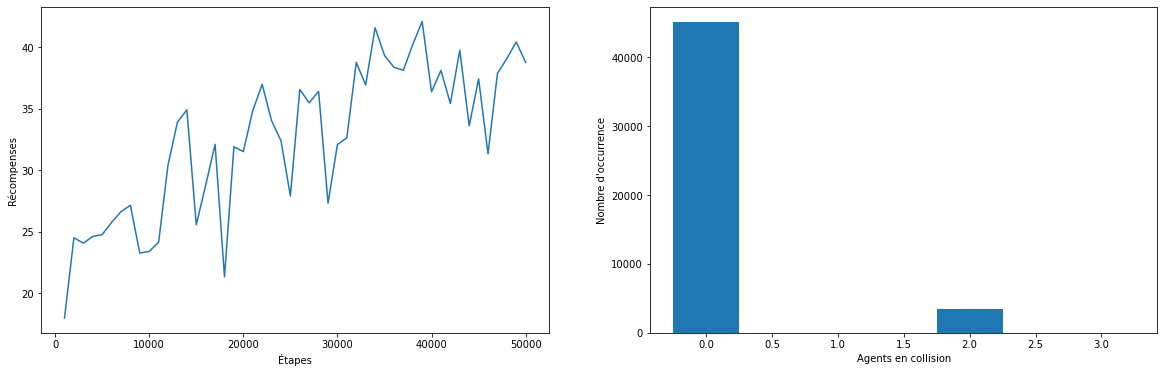

In [14]:
bins = []
for x in range(nb_agents+1):
    bins.append(x-0.5)
    bins.append(x+0.5)
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(steps, avg)
plt.xlabel("Étapes")
plt.ylabel("Récompenses")
plt.subplot(1, 2, 2)
plt.hist(train_py_env.agents_in_collision, bins=bins, rwidth=0.5)
plt.xlabel("Agents en collision")
plt.ylabel("Nombre d'occurrence")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


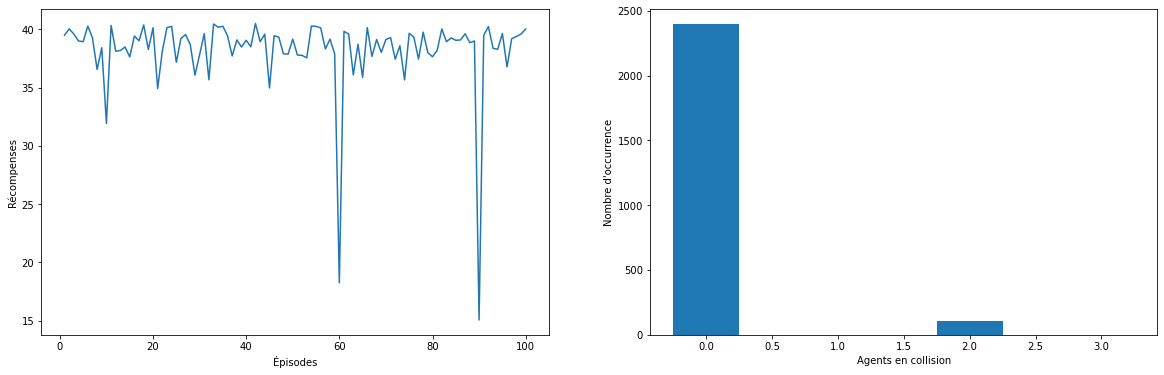

In [15]:
rewards = []
episodes = 100
a = len(eval_py_env.agents_in_collision)
for _ in tqdm(range(episodes)):
    time_step = eval_env.reset()
    episode_return = 0.0
    while not time_step.is_last():
        actions = []
        for i in range(nb_agents):
            actions.append(eval_policies[i].action(time_step).action.numpy()[0])
        actions = tf.convert_to_tensor([actions])
        time_step = eval_env.step(actions)
        episode_return += time_step.reward
    rewards.append(episode_return.numpy()[0])
    
bins = []
for x in range(nb_agents+1):
    bins.append(x-0.5)
    bins.append(x+0.5)
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(range(1, episodes+1), rewards)
plt.xlabel("Épisodes")
plt.ylabel("Récompenses")
plt.subplot(1, 2, 2)
plt.hist(eval_py_env.agents_in_collision[a:], bins=bins, rwidth=0.5)
plt.xlabel("Agents en collision")
plt.ylabel("Nombre d'occurrence")
plt.show()

In [16]:
cpt  = 0
for ele in eval_py_env.agents_in_collision[a:]:
    if ele!=0:
        cpt += 1
print(cpt)

104


In [ ]:
for i in range(nb_agents):
    policies_checkpointers[i].save(global_step=agents_tf[i].train_step_counter)